In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# Intialisation

In [26]:
import nltk
import seaborn as sns
import pandas as pd
import json
import pickle
import warnings
import numpy as np
import tensorflow as tf
import random

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
from nltk.stem import WordNetLemmatizer

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.utils import plot_model

from sklearn.metrics import roc_curve, auc
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

nltk.download('punkt')#Sentence tokenizer
ops.reset_default_graph()
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Explanation: This section initializes the necessary variables and imports the required libraries.
## Notes:
#### - 'words': An empty list to store all unique words found in the patterns.
#### - 'classes': An empty list to store all unique intent tags.
#### - 'documents': An empty list to store tuples of words and associated intent tags.
#### - 'ignore_words': A list of punctuation symbols to be ignored during tokenization.
#### - 'data_file': Opens the JSON file containing the intents and reads its contents.
#### - 'intents': Parses the JSON data into a Python dictionary containing intent tags, patterns, and responses.


In [27]:
words=[]
classes = []
documents = []
ignore_words = ['?', '!']
data_file = open('/content/gdrive/MyDrive/Internship_Project/intents.json').read() # read json file
intents = json.loads(data_file) # load json file

# Data Preprocessing & EDA

### When dealing with text data, there are a number of preprocessing steps that must be taken before creating a machine learning or deep learning model. One must preprocess the data using a variety of processes in accordance with the requirements.

----

#### 1) The simplest and initial action you can take with text data is tokenisation.
#### 2) Tokenising is the act of dividing the entire text into discrete units, such as words.
#### 3) Next, we append each word in the words list and iterate through the patterns, tokenising the sentence using the nltk.word_tokenize() method. For our tags, we also make a list of classes.






In [28]:
# Extracting all words and classes
words = [word for intent in intents['intents'] for pattern in intent['patterns'] for word in nltk.word_tokenize(pattern)]
classes = list(set(intent['tag'] for intent in intents['intents']))

# Generating documents
documents = [(nltk.word_tokenize(pattern), intent['tag']) for intent in intents['intents'] for pattern in intent['patterns']]

In [29]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [30]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Lemmatisation is performed immediately after tokenisation to standardize the words in the dataset and improve the quality of the input data for the chatbot model.
---
# Notes:
--
#### 1) Lemmatisation reduces words to their base or dictionary form (lemma), which helps in reducing the vocabulary size and improving model generalisation by treating different inflected forms of a word as a single entity.
#### 2) Lowercasing the words ensures uniformity and consistency in the dataset, preventing the model from treating the same word differently based on its case.
#### 3) Removing duplicates after lemmatisation ensures that each unique word contributes meaningfully to the model's understanding, reducing redundancy and improving efficiency.
#### 4) The sorted list of lemmatised words provides a standardised vocabulary for the model, facilitating feature extraction and training.
#### 5) Standardising the input data through lemmatisation, lowercasing, and removal of duplicates is essential for building robust and effective chatbot models that can accurately understand and respond to user queries across different variations of input text.


In [31]:
lemmatizer = WordNetLemmatizer()

# Lemmatize, lowercase each word, and remove duplicates
words = sorted(list(set([lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words])))

# Sort classes
classes = sorted(classes)

# Print information
print(len(documents), "documents\n", documents, "\n")
print(len(classes), "classes\n", classes, "\n")
print(len(words), "unique lemmatized words\n", words, "\n")

# Save to pickle files
with open('words.pkl', 'wb') as f:
    pickle.dump(words, f)

with open('classes.pkl', 'wb') as f:
    pickle.dump(classes, f)

47 documents
 [(['Hi', 'there'], 'greeting'), (['How', 'are', 'you'], 'greeting'), (['Is', 'anyone', 'there', '?'], 'greeting'), (['Hey'], 'greeting'), (['Hola'], 'greeting'), (['Hello'], 'greeting'), (['Good', 'day'], 'greeting'), (['Bye'], 'goodbye'), (['See', 'you', 'later'], 'goodbye'), (['Goodbye'], 'goodbye'), (['Nice', 'chatting', 'to', 'you', ',', 'bye'], 'goodbye'), (['Till', 'next', 'time'], 'goodbye'), (['Thanks'], 'thanks'), (['Thank', 'you'], 'thanks'), (['That', "'s", 'helpful'], 'thanks'), (['Awesome', ',', 'thanks'], 'thanks'), (['Thanks', 'for', 'helping', 'me'], 'thanks'), (['How', 'you', 'could', 'help', 'me', '?'], 'options'), (['What', 'you', 'can', 'do', '?'], 'options'), (['What', 'help', 'you', 'provide', '?'], 'options'), (['How', 'you', 'can', 'be', 'helpful', '?'], 'options'), (['What', 'support', 'is', 'offered'], 'options'), (['How', 'to', 'check', 'Adverse', 'drug', 'reaction', '?'], 'adverse_drug'), (['Open', 'adverse', 'drugs', 'module'], 'adverse_drug')

#### To summarise, implementing lemmatisation immediately after tokenisation helps standardise input text data by reducing words to their base forms, assuring consistency, and boosting feature quality for the chatbot model. This stage is critical for developing strong and effective chatbots that can understand and answer appropriately to user queries.

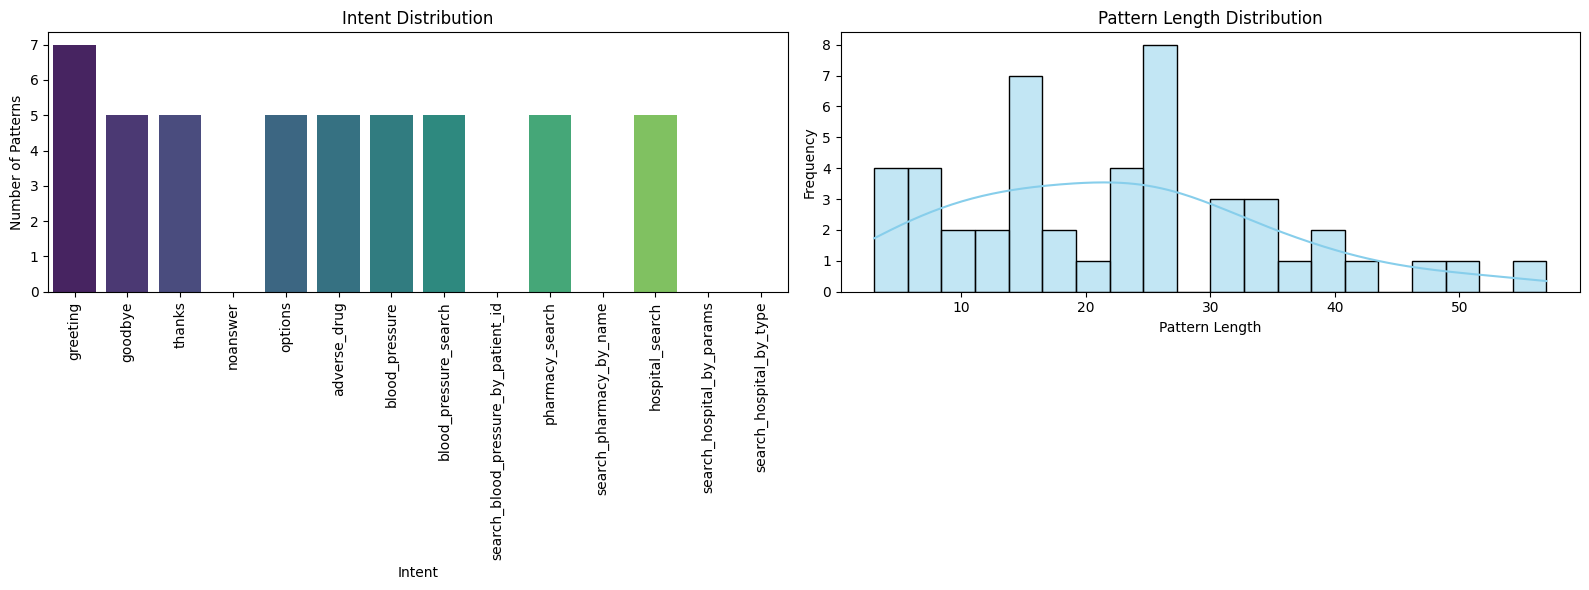

In [32]:
# Intent Distribution
intent_counts = {intent['tag']: len(intent['patterns']) for intent in intents['intents']}

# Pattern Length Distribution
pattern_lengths = [len(pattern) for intent in intents['intents'] for pattern in intent['patterns']]

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Intent Distribution
sns.barplot(x=list(intent_counts.keys()), y=list(intent_counts.values()), ax=axes[0], palette='viridis')
axes[0].set_title('Intent Distribution')
axes[0].set_xlabel('Intent')
axes[0].set_ylabel('Number of Patterns')
axes[0].tick_params(axis='x', rotation=90, labelsize=10)
axes[0].tick_params(axis='y', labelsize=10)

# Plot Pattern Length Distribution
sns.histplot(pattern_lengths, bins=20, kde=True, ax=axes[1], color='skyblue')
axes[1].set_title('Pattern Length Distribution')
axes[1].set_xlabel('Pattern Length')
axes[1].set_ylabel('Frequency')
axes[1].tick_params(axis='both', labelsize=10)

# Add space between subplots
plt.tight_layout()

# Show plot
plt.show()

### Intent Distribution Key Findings & Interpretations:

### findings:-
#### *) The “greeting” intent has the highest number of patterns, followed by “goodbye” and “thanks”.
#### *) Intents like “search_blood_pressure_by_patient_id”, “search_pharmacy_by_medicine_name”, and others have fewer patterns.
#### *) Overall, the intents are distributed unevenly, with some being more common than others.
-
### Interpretations:-
#### Effect on conversational flow:
  #### Intents with more patterns, such as "greeting," "goodbye," and "thanks," are typical conversation starters and enders. This implies that consumers commonly initiate and end discussions with the chatbot using these intents.
-
#### Handling Common Scenarios:
#### The uneven distribution of intents indicates that the chatbot should be well-prepared to handle typical scenarios such as greetings, farewells, and expressions of thanks.
-
#### Resource Allocation:
####  Because some intents contain fewer patterns, it's critical to invest resources appropriately during model training and development to guarantee that less common scenarios are handled correctly.
---

### Pattern Length Distribution Key Findings & Interpretations:

### findings:-
#### *) Most patterns are between 10 and 20 characters in length.
#### *) As the pattern length exceeds 20 characters, the frequency decreases dramatically.
#### *) There are very few patterns longer than 40 characters.
#### *) In conclusion, the majority of patterns are succinct, with a peak of 10-20 characters.
-
### Interpretations:-
#### Impact on Understanding:
#### The bulk of patterns are between 10 and 20 characters long, indicating that consumers send short questions or messages to the chatbot.
-
#### Handling Long Questions:
####  As the pattern length exceeds 20 characters, the frequency decreases dramatically, showing that longer enquiries are less common. Longer queries may be difficult for the chatbot to understand and react to due to their low frequency and potential complexity.
-
#### Response Length Considerations:  
####  Given the pattern length distribution, the chatbot's responses should be adjusted to the length of the input query. Longer requests may necessitate more extensive and informative responses, whereas shorter ones may be addressed more concisely.

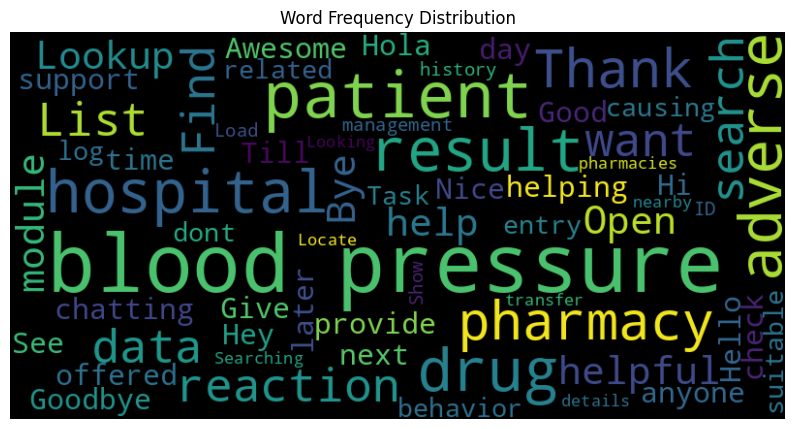

In [33]:
# Combine all patterns into a single string
all_patterns = ' '.join([pattern for intent in intents['intents'] for pattern in intent['patterns']])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(all_patterns)

# Plot word cloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Frequency Distribution')
plt.axis('off')  # Turn off axis
plt.show()

# Training Data Preparation:

#### This step defines the model's input and output. Input consists of patterns (textual sequences) while output corresponds to their respective classes (intents). However, computers require numerical representations for processing text.

## Bag-of-Words Representation:

#### This technique converts each pattern into a vector. Each element represents a distinct word from the vocabulary, signifying its presence (1) or absence (0) within the pattern.

## Output Representation:

#### Similarly, an output array is created for each pattern. Its length matches the number of classes. Each element indicates the pattern's class membership (1) or not (0).
---
#### This training data provides the model with input-output pairs, enabling it to learn the relationship between patterns and their corresponding classes. Upon training, the model acquires the ability to accurately classify new patterns into the appropriate classes.

In [34]:
# create our training data
training = []
# create an empty array for our output
output_empty = [0] * len(classes)
# training set, bag of words for each sentence
for doc in documents:
    # initialize our bag of words
    bag = []
    # list of tokenized words
    pattern_words = doc[0]
    # convert pattern_words in lower case
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]
    # create bag of words array,if word match found in current pattern then put 1 otherwise 0.[row * colm(263)]
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)

    # in output array 0 value for each tag ang 1 value for matched tag.[row * colm(8)]
    output_row = list(output_empty)
    output_row = [0] * len(bag)
    output_row[classes.index(doc[1])] = 1

    training.append([bag, output_row])
# shuffle training and turn into np.array
random.shuffle(training)
training = np.array(training)
# create train and test. X - patterns(words), Y - intents(tags)
train_x = list(training[:,0])
train_y = list(training[:,1])
print("Training data created")

Training data created


# Model Building, Training

## model_architecture

In [35]:
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation='softmax'))

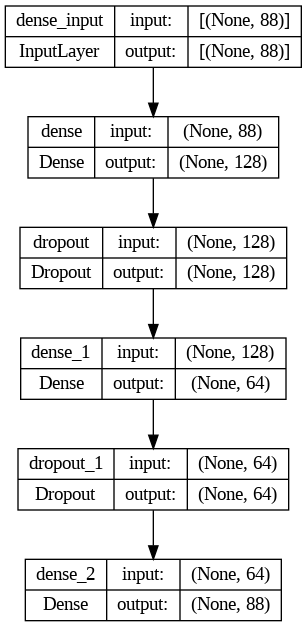

In [36]:
# Plot model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True)

## Setting Up Learning rate and callback functions

In [37]:
# Define a learning rate schedule function
def lr_schedule(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        lr = lr * 0.9  # decrease learning rate by 10% every 10 epochs
    return lr

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
lr_scheduler = LearningRateScheduler(lr_schedule)  # Learning rate scheduling
early_stopping = EarlyStopping(patience=5, monitor='val_loss')  # Early stopping

## Model Fitting and visuvalisations

In [ ]:
# Train the model with callbacks

hist = model.fit(np.array(train_x), np.array(train_y), epochs=99, batch_size=5, verbose=1, callbacks=[lr_scheduler, early_stopping])

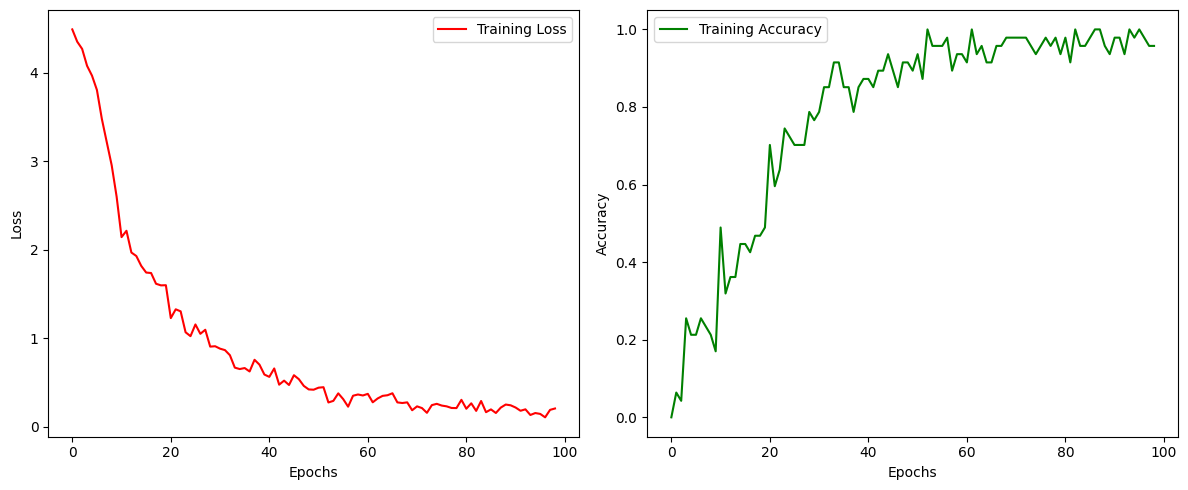

In [39]:
import matplotlib.pyplot as plt

# Assuming hist is the history object obtained from model training

# Create a figure and two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot training loss
axs[0].plot(hist.history['loss'], label='Training Loss', color='red')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot training accuracy
axs[1].plot(hist.history['accuracy'], label='Training Accuracy', color='green')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()  # Apply tight layout to adjust spacing
plt.show()


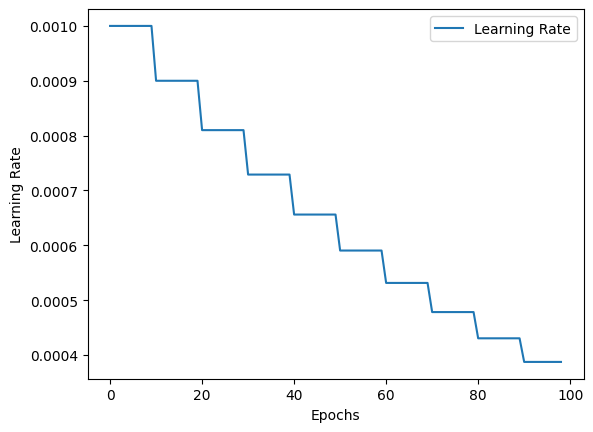

In [40]:
# Plot learning rate
plt.plot(hist.history['lr'], label='Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.show()

# Saving Model

In [41]:
# Define the path where you want to save the model
model_path = '/content/gdrive/MyDrive/Internship_Project/model/Hospital_chatbot1.h5'

# Save the model to the specified location
model.save(model_path)

print(f"Model saved to: {model_path}")

Model saved to: /content/gdrive/MyDrive/Internship_Project/model/Hospital_chatbot1.h5


# Model Precicting & Chatbot Interaction

In [42]:
model = load_model('/content/gdrive/MyDrive/Internship_Project/model/Hospital_chatbot1.h5')

In [43]:
intents = json.loads(open('/content/gdrive/MyDrive/Internship_Project/intents.json').read())

words = pickle.load(open('words.pkl','rb'))

classes = pickle.load(open('classes.pkl','rb'))

## Setting up functions for predicting

### since we haven't crafted a sepeate testing dataset, we must remeber to upack the data same as we prepared the data to predict and use the chatbot

#### 1) Tokenizes and lemmatizes "input"
#### 2) Converts input into bag of words
#### 3) Predicting the intent of input using our "Trained Model"
#### 4) Retrive responses based on previous predictions
#### 5) Finally designing a "chatbot response" functions conntecting one another

In [44]:
limited_knowledge_responses = [
    "My knowledge is limited. I'm still learning. Could you provide more details or ask another question?",
    "I'm sorry, I don't have enough information on that. Can you provide more context or ask another question?",
    "Hmm, I'm not sure about that. Can you give me more details or ask something else?",
    "Sorry i didn't get that, could you please offer further information or ask a different question?",
    "I'm sorry, I can't answer that could you please rephrase the question"
]

#----------------Tokenizes and lemmatizes the input sentence-------------------#
def clean_up_sentence(sentence):
    lemmatizer = nltk.WordNetLemmatizer()
    return [lemmatizer.lemmatize(word.lower()) for word in nltk.word_tokenize(sentence)]

#------Converts the cleaned sentence into a bag of words representation--------#
def bow(sentence, words):
    sentence_words = clean_up_sentence(sentence)
    return np.array([1 if word in sentence_words else 0 for word in words])

#-------Predicts the intent of the input sentence using the trained model------#
def predict_class(sentence, model, classes, threshold=0.50): # setting threshold to ".50" to match the user input most of the time with atleast 50% matching
    p = bow(sentence, words)
    res = model.predict(np.array([p]))[0]
    results = [(i, r) for i, r in enumerate(res) if r > threshold]
    results.sort(key=lambda x: x[1], reverse=True)
    return [{'intent': classes[r[0]], 'probability': str(r[1])} for r in results]

#-----------Retrieves a response based on the predicted intent-----------------#
def get_response(intents, predicted_intent):
    for intent in intents['intents']:
        if intent['tag'] == predicted_intent:
            return random.choice(intent['responses'])
    return "I'm sorry, I didn't understand that."

#--------Provides a response from the chatbot based on the input text----------#
def chatbot_response(text, model, words, classes, intents):
    if not text.strip():
        return "Please enter your query."

    predicted_intents = predict_class(text, model, classes)
    if not predicted_intents:
        return random.choice(limited_knowledge_responses)

    predicted_intent = predicted_intents[0]['intent']
    if predicted_intent == 'noanswer':
        return "I can't answer that. Can I forward you to a real assistant?"

    return get_response(intents, predicted_intent)

In [47]:
print("Chatbot: Hello! How can I assist you today? (type 'quit' to exit)")
while True:
    user_input = input("You: ")
    if user_input.lower() == 'quit' or user_input.lower() == 'exit' or user_input.lower() == 'end':
        print("Chatbot: Goodbye! Have a great day!")
        break
    response = chatbot_response(user_input, model, words, classes, intents)
    print("Chatbot:", response)

Chatbot: Hello! How can I assist you today? (type 'quit' to exit)
You: hola
1/1 [==============================] - 0s 21ms/step
Chatbot: Hi there, how can I help?
You: can you teach me music
1/1 [==============================] - 0s 28ms/step
Chatbot: I can guide you through Adverse drug reaction list, Blood pressure tracking, Hospitals and Pharmacies
You: no teach me music ??
1/1 [==============================] - 0s 21ms/step
Chatbot: I'm sorry, I don't have enough information on that. Can you provide more context or ask another question?
You: oh okay
1/1 [==============================] - 0s 39ms/step
Chatbot: I'm sorry, I can't answer that could you please rephrase the question
You: i want to know about hospitals
1/1 [==============================] - 0s 22ms/step
Chatbot: Please provide hospital name or location
You: thanks 
1/1 [==============================] - 0s 21ms/step
Chatbot: My pleasure
You: bye
1/1 [==============================] - 0s 31ms/step
Chatbot: See you!
You: e